## OpenPIV tutorial of all test cases

In [1]:
from openpiv import tools, pyprocess, scaling, validation, filters
import numpy as np
import glob
%matplotlib inline

In [2]:
# set of typical parameters
window_size = 32  # pixels 32 x 32 pixels interrogation window, in frame A.
overlap = 8  # overlap is 8 pixels, i.e. 25% of the window
search_size = 64  # pixels 64 x 64 in frame B, avoids some peak locking for 
                  # large displacements

In [3]:
def openpiv_default_run(im1,im2):
    """ default settings for OpenPIV analysis using
    extended_search_area_piv algorithm for two images
    
    Inputs:
        im1,im2 : str,str = path of two image
    """
    frame_a  = tools.imread(im1)
    frame_b  = tools.imread(im2)

    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=window_size, 
                                                       overlap=overlap, 
                                                       dt=1, 
                                                       search_area_size=search_size, 
                                                       sig2noise_method='peak2peak' )
    x, y = pyprocess.get_coordinates(frame_a.shape, 
                                     search_size, 
                                     overlap)
    u, v, mask = validation.sig2noise_val(u, v, sig2noise, threshold = 1.3 )
    u, v = filters.replace_outliers( u, v, method='localmean', 
                                    max_iter=3, kernel_size=3)
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1. )
    tools.save(x, y, u, v, sig2noise, mask, list_of_images[0]+'.txt' )
    fig,ax = tools.display_vector_field(list_of_images[0]+'.txt', 
                                        on_img=True,image_name=list_of_images[0],
                                        scaling_factor=1.,
                                        ax=None)

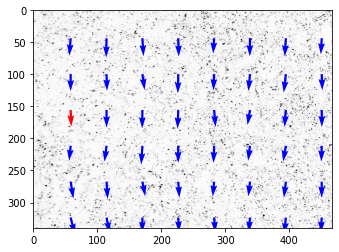

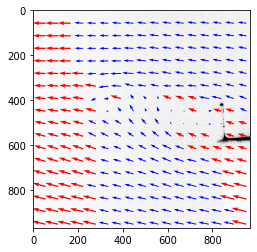

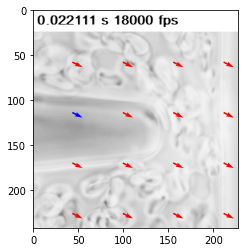

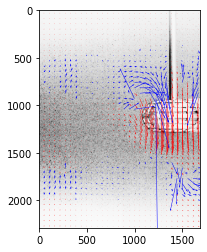

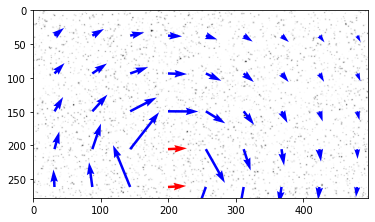

/home/user/miniconda3/envs/windef/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/miniconda3/envs/windef/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/miniconda3/envs/windef/lib/python3.8/site-packages/matplotlib/quiver.py:670: RuntimeWarning: Mean of empty slice.
  amean = a.mean()


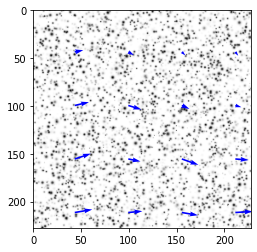

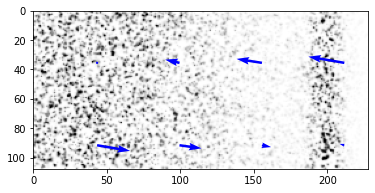

/home/user/Downloads/repos/openpiv-python/openpiv/pyprocess.py:298: RuntimeWarning: invalid value encountered in double_scalars
  peak1_j + ((log(cd) - log(cu)) / (2 * log(cd) - 4 * log(c) + 2 * log(cu))),
/home/user/Downloads/repos/openpiv-python/openpiv/pyprocess.py:297: RuntimeWarning: invalid value encountered in double_scalars
  peak1_i + ((log(cl) - log(cr)) / (2 * log(cl) - 4 * log(c) + 2 * log(cr))),


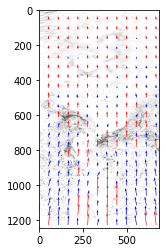

In [4]:
alist_filter = ['jpg','bmp','png','tif','tiff']


# all test cases in /openpiv/examples/
list_of_tests = glob.glob('../test*')
list_of_tests.sort()

list_of_images = []
for test in list_of_tests:
    
    list_of_files = glob.glob(test+'/*.*')
    list_of_files.sort()
    list_of_images = [f for f in list_of_files if f[-3:] in alist_filter]
    
    openpiv_default_run(list_of_images[0],list_of_images[1])